<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/ColabNotebooks/FasterRCNN/VGG16_FRCNN_vote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/20220819'
/content/drive/MyDrive/Colab Notebooks/20220819
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset, default_collate
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from pycocotools.coco import COCO

import utils
from WoodDataset import FasterRCNN_WoodDataset

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [25]:
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [26]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip, ISONoise, RandomContrast
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(512, 1024), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),  
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(512, 1024), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [27]:
train_data = FasterRCNN_WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = FasterRCNN_WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = FasterRCNN_WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [28]:
batch_size = 8
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [29]:
from Models import FasterRCNN_Backbone_VGG16
modelname = 'VGG16'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(FasterRCNN_Backbone_VGG16(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)

start_epoch = 387
checkpoint_path = os.path.join('models', 'FasterRCNN', f'VGG16_SGD_epoch_{start_epoch}.pth')
if os.path.exists(checkpoint_path):
  model.load_state_dict(torch.load(checkpoint_path))

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=1e-4, momentum=0.9)
lr_scheduler = None

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FasterRCNN_Backbone_VGG16(
    (vgg16): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, ke

In [30]:
num_epochs = 500
total_train_loss = []
total_valid_loss = []


In [31]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('FasterRCNN_logs_v2', f'FasterRCNN_{modelname}_{optimizer_type}')
writer = SummaryWriter(logdir)

In [ ]:
def train_batch(model, images, targets):
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  loss_dict = model(images, targets)
  return loss_dict

In [ ]:
torch.manual_seed(2)
model.train()
t0 = time.time()
best_valid_loss = np.array([1000., 1000., 1000., 1000.])
last_update_epoch = 0
for epoch in range(start_epoch, num_epochs):

    train_box_loss = []
    train_cls_loss = []
    train_obj_loss = []
    train_rpn_loss = []
    valid_box_loss = []
    valid_cls_loss = []
    valid_obj_loss = []
    valid_rpn_loss = []
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:
        torch.cuda.empty_cache()
        batch_size = len(images)
        n += 1

        loss_dict = train_batch(model, images, targets)
        '''
        loss__dict = {'loss_classifier': ###, 
                      'loss_box_reg': ###, 
                      'loss_objectness': ###, 
                      'loss_rpn_box_reg': ###}
        '''        
        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()

        train_box_loss.append(box_loss)
        train_cls_loss.append(cls_loss)
        train_obj_loss.append(obj_loss)
        train_rpn_loss.append(rpn_loss)

        losses = sum(loss_dict.values())     # Returns losses and detections

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        now = time.time()

        if n % 100 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] box_loss: {box_loss:.4f}  cls_loss: {cls_loss:.4f}  obj_loss: {obj_loss:.4f}  rpn_loss: {rpn_loss:.4f}')
          print(f'Training time: {tstr}')      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    images = None
    targets = None  
    loss_dict = None  
    torch.cuda.empty_cache()
############################# valid #########################################
    with  torch.no_grad():        
      for images, targets in valid_data_loader:

          torch.cuda.empty_cache()
          loss_dict = train_batch(model, images, targets)

          cls_loss = loss_dict['loss_classifier'].item()
          box_loss = loss_dict['loss_box_reg'].item()
          obj_loss = loss_dict['loss_objectness'].item()
          rpn_loss = loss_dict['loss_rpn_box_reg'].item()
          losses = sum(loss_dict.values())

          valid_box_loss.append(box_loss)
          valid_cls_loss.append(cls_loss)
          valid_obj_loss.append(obj_loss)
          valid_rpn_loss.append(rpn_loss)
          # val_loss_hist.send(val_loss_value)
    images = None
    targets = None 
    loss_dict = None
    torch.cuda.empty_cache()

############################ log ###########################################
    epoch_train_box_loss = np.mean(train_box_loss)
    epoch_train_cls_loss = np.mean(train_cls_loss)
    epoch_train_obj_loss = np.mean(train_obj_loss)
    epoch_train_rpn_loss = np.mean(train_rpn_loss)
    epoch_valid_box_loss = np.mean(valid_box_loss)
    epoch_valid_cls_loss = np.mean(valid_cls_loss)
    epoch_valid_obj_loss = np.mean(valid_obj_loss)
    epoch_valid_rpn_loss = np.mean(valid_rpn_loss)

    current_valid_loss = np.array([epoch_valid_box_loss, 
                              epoch_valid_cls_loss, 
                              epoch_valid_obj_loss, 
                              epoch_valid_rpn_loss])

    now = time.time()
    writer.add_scalar('train/box_loss', epoch_train_box_loss, epoch, now)
    writer.add_scalar('train/cls_loss', epoch_train_cls_loss, epoch, now)
    writer.add_scalar('train/obj_loss', epoch_train_obj_loss, epoch, now)
    writer.add_scalar('train/rpn_loss', epoch_train_rpn_loss, epoch, now)
    writer.add_scalar('valid/box_loss', epoch_valid_box_loss, epoch, now)
    writer.add_scalar('valid/cls_loss', epoch_valid_cls_loss, epoch, now)
    writer.add_scalar('valid/obj_loss', epoch_valid_obj_loss, epoch, now)
    writer.add_scalar('valid/rpn_loss', epoch_valid_rpn_loss, epoch, now)

############################ save ##########################################   
    if sum(current_valid_loss < best_valid_loss) >= 3:
        best_valid_loss = current_valid_loss
        print(f'Model Updated! Validation box_loss: {best_valid_loss[0]:.4f}  cls_loss: {best_valid_loss[1]:.4f}  obj_loss: {best_valid_loss[2]:.4f}  rpn_loss: {best_valid_loss[3]:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}.pth'
        torch.save(model.state_dict(), os.path.join('models', 'FasterRCNN', save_name))

        if os.path.exists(os.path.join('models', 'FasterRCNN', last_save_name)):
          os.remove(os.path.join('models', 'FasterRCNN', last_save_name))
        last_update_epoch = epoch
#############################################################################
writer.close()

Epoch: [313] [100/361] box_loss: 0.0696  cls_loss: 0.0429  obj_loss: 0.0111  rpn_loss: 0.0149
Training time: 00:05:18
Epoch: [313] [200/361] box_loss: 0.0787  cls_loss: 0.0500  obj_loss: 0.0191  rpn_loss: 0.0150
Training time: 00:10:17
Epoch: [313] [300/361] box_loss: 0.0581  cls_loss: 0.0297  obj_loss: 0.0098  rpn_loss: 0.0054
Training time: 00:15:13
Model Updated! Validation box_loss: 0.0727  cls_loss: 0.0439  obj_loss: 0.0133  rpn_loss: 0.0115
Epoch: [314] [100/361] box_loss: 0.0587  cls_loss: 0.0371  obj_loss: 0.0170  rpn_loss: 0.0061
Training time: 00:21:22
Epoch: [314] [200/361] box_loss: 0.0719  cls_loss: 0.0426  obj_loss: 0.0223  rpn_loss: 0.0191
Training time: 00:22:17
Epoch: [314] [300/361] box_loss: 0.0626  cls_loss: 0.0441  obj_loss: 0.0202  rpn_loss: 0.0213
Training time: 00:23:11
Model Updated! Validation box_loss: 0.0726  cls_loss: 0.0434  obj_loss: 0.0133  rpn_loss: 0.0114
Epoch: [315] [100/361] box_loss: 0.0802  cls_loss: 0.0499  obj_loss: 0.0119  rpn_loss: 0.0051
Trai

In [32]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou

idx = 15
model.eval().to(device)
with torch.no_grad():
  rec = model(test_data[idx][0].unsqueeze(0).to(device))
  rec = rec[0]


In [ ]:
bbox_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox = rec['boxes'][bbox_idx].cpu()
labels = rec['labels'][bbox_idx].cpu()

In [ ]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([8, 6, 2])

Text(0.5, 1.0, 'Gt')

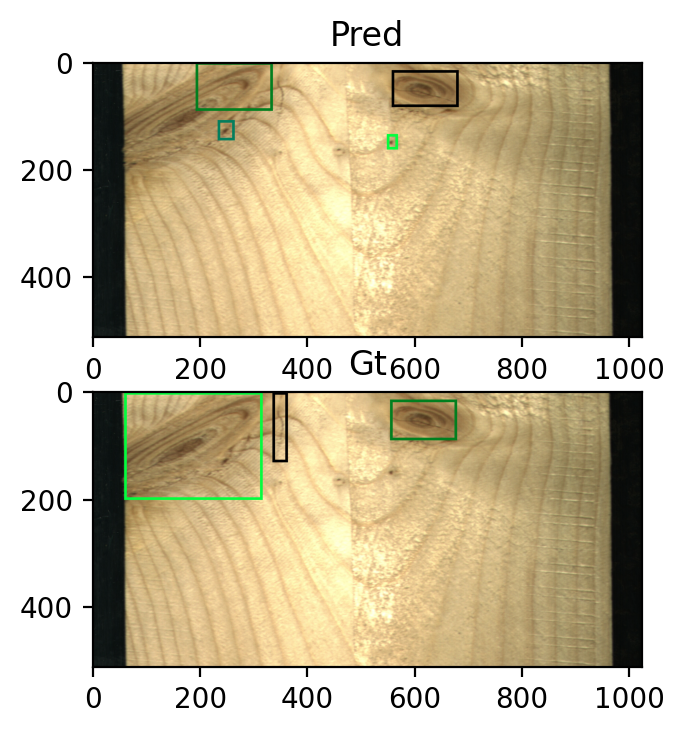

In [ ]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [ ]:
result = {'boxes':bbox.cpu(), 
          'idx': idx, 
          'labels': labels.cpu()}
# np.save('test.npy', result)
# test = np.load('test.npy', allow_pickle=True)

In [ ]:
import pickle
# with open('test.dict', 'wb') as f:
#   pickle.dump(result, f)

with open('test.dict', 'rb') as f:
  a = pickle.load(f)
a

{'boxes': tensor([[566.8190,  15.8686, 655.2360,  81.5210],
         [ 80.7732,  70.6825, 299.7254, 147.6548],
         [219.6724,   1.2643, 310.7099,  49.6471],
         [546.0529, 137.2273, 555.8708, 156.8440]], requires_grad=True),
 'idx': 15,
 'labels': tensor([2, 2, 2, 2])}

In [ ]:
cm

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.6202, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3279, 0.0857, 0.0000]], grad_fn=<DivBackward0>)

In [ ]:
cm = box_iou(bbox_gt, bbox)
TP = (cm >= 0.5).sum()
FP = len(bbox) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc


tensor(0.2500)

In [ ]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0., 0., 0.]])

In [33]:
ious = []
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))
for idx in range(len(test_data)):
  image = test_data[idx][0]
  target = test_data[idx][1]
  with torch.inference_mode():
    rec = model(image.unsqueeze(0).to(device))
    rec = rec[0]

  nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
  bbox_pred = rec['boxes'][nms_idx].cpu()
  labels_pred = rec['labels'][nms_idx].cpu()

  bbox_gt = target['boxes']
  labels_gt = target['labels']

  cm = box_iou(bbox_gt, bbox_pred)
  box_TP = (cm>0.5).sum()
  box_FP = len(bbox_pred) - box_TP
  box_FN = len(bbox_gt) - box_TP

  box_precision = box_TP/(box_TP + box_FP + eps)
  box_recall = box_TP/(box_TP + box_FN + eps)

  box_precisions.append(box_precision)
  box_recalls.append(box_recall)

  gt2 = labels_gt[cm.argmax(dim=0)]
  for i in range(len(gt2)):
    cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

  if (idx+1) % 30 == 0:
    print(f'Done {idx+1}/{len(test_data)}')


Done 30/361
Done 60/361
Done 90/361
Done 120/361
Done 150/361
Done 180/361
Done 210/361
Done 240/361
Done 270/361
Done 300/361
Done 330/361
Done 360/361


In [36]:
with open(os.path.join('Classification_matrix', 'VGG16_FRCNN_vote.npy'), 'wb') as f:
  np.save(f, cls_cm)

In [ ]:
cls_cm

array([[ 11.,   7.,   5.,   4.,   1.,   0.,   0.,   0.],
       [ 11., 401.,   0.,   5.,  43.,  13.,   4.,   6.],
       [  5.,  10.,  16.,   3.,   1.,   0.,   0.,   1.],
       [  5.,  13.,   2.,  66.,   3.,   0.,   1.,   9.],
       [ 17.,  67.,   0.,  24., 227.,   2.,   4.,  10.],
       [  1.,  42.,   0.,   2.,   4.,  21.,   0.,   0.],
       [  0.,   3.,   0.,   1.,   1.,   0.,   7.,   1.],
       [  1.,   4.,   0.,   4.,   0.,   0.,   0.,  29.]])

In [34]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
cls_precision

array([0.21568627, 0.73308958, 0.69565214, 0.60550458, 0.81071428,
       0.58333332, 0.43749997, 0.51785713])

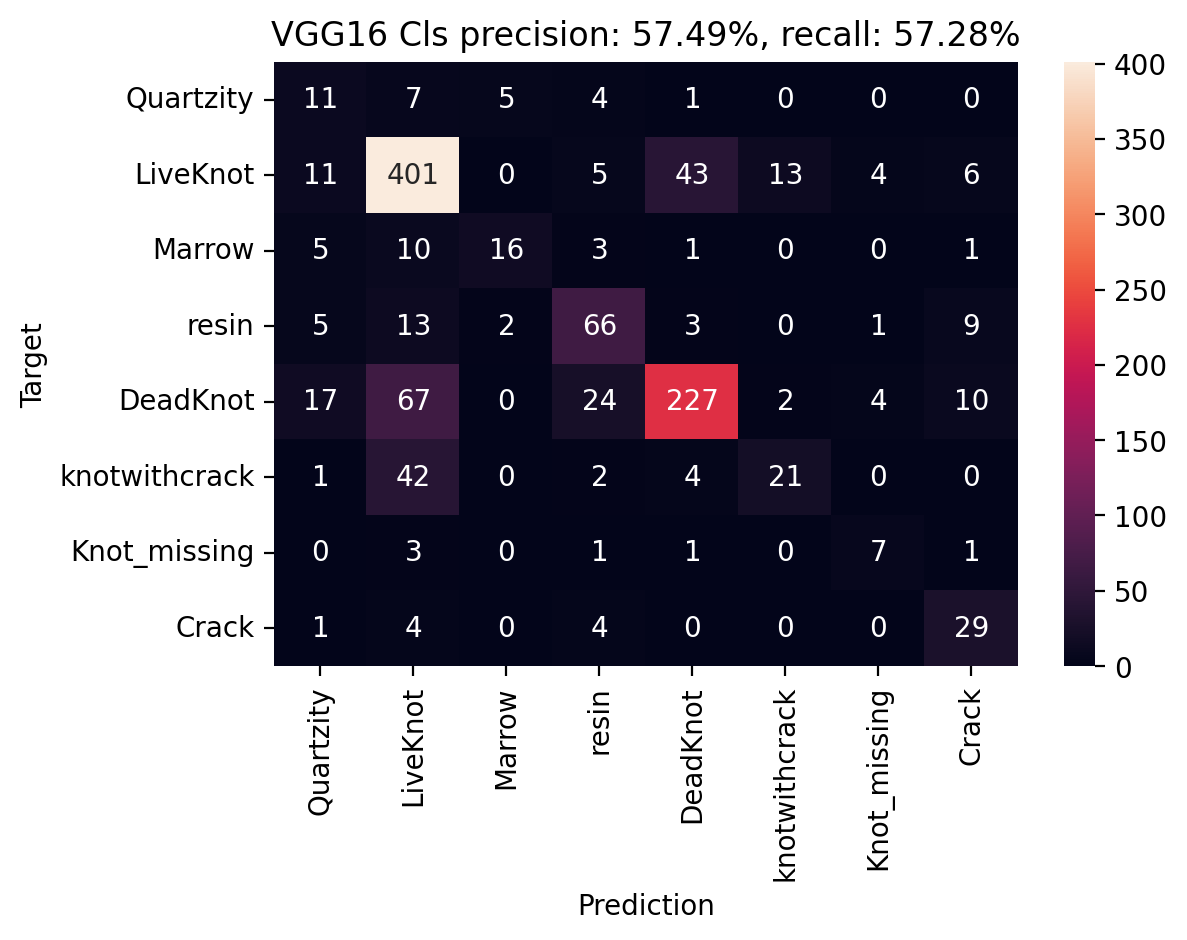

In [35]:
import seaborn as sn
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'VGG16 Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}%')
plt.savefig(os.path.join('Classification_matrix', 'VGG16_FRCNN_vote.png'))
           

In [ ]:
import pandas as pd
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']


In [ ]:
mean_box_precision = df['box_precision'].mean()
mean_box_recall = df['box_recall'].mean()
mean_cls_precision = cls_precision.mean()
mean_cls_recall = cls_recall.mean()
print(f'Box precision: {mean_box_precision:.4f}')
print(f'Box recall: {mean_box_recall:.4f}')
print(f'Class precision: {mean_cls_precision:.4f}')
print(f'Class recall: {mean_cls_recall:.4f}')

Box precision: 0.7579
Box recall: 0.8935
Class precision: 0.5749
Class recall: 0.5728


In [ ]:
# save_name = 'VGG16_SGD_epoch_20.pth'
# df.to_csv(os.path.join('Validation_csv', save_name.replace('pth', 'csv')))